In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wget

url = "https://raw.githubusercontent.com/LCAV/pyroomacoustics/master/examples/data/INRIA_MUSIS.stl"
mesh_url = "../tmp/INRIA_MUSIS.stl"

from pathlib import Path
if not Path(mesh_url).is_file():
    print(f"download data to {mesh_url}")
    wget.download(url, mesh_url)
else:
    print("data already downloaded")

data already downloaded


#### capture depth map

[6722.1406914247345, 12345.640691424735, 10572.140691424735]
[6722.14069142] [12345.64069142] [10572.14069143]


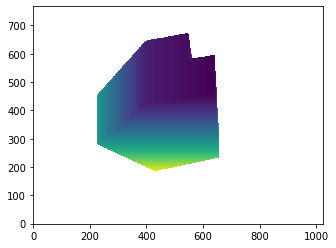

In [3]:
import src.dmcp_workflow.capture_depth as cd
import matplotlib.pyplot as plt
import scipy.linalg as la

dm, Kdm, Pdm = cd.generate_depth_map(mesh_url)

%matplotlib inline
plt.imshow(dm, origin="lower")
plt.show()

pick 3d point to compare

In [4]:
import pyvista as pv
mesh = pv.read(mesh_url)

#points = []
#def on_click(point):
#    points.append(point)

point = None
def on_click(p):
    global point
    point = p

p = pv.Plotter()
p.add_mesh(mesh, pickable=True, color="green")
p.enable_point_picking(callback=on_click,pickable_window=False)  # Make the 3D window unpickable
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [5]:
print(point)
import numpy as np

p3D = point
#p3D = np.array([-1549.18237305 , 6047.  ,        1000.01623535])
p2d = np.array([394.0, 413.0])

[-989.36566162 5231.93505859 1000.01623535]


[551.38577834 534.90936134]


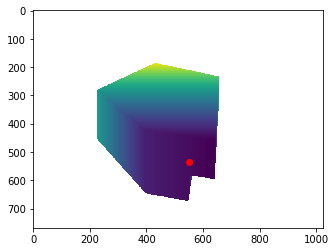

In [6]:
x_hat = np.matmul(Pdm, np.append(p3D, 1))
x_hat = x_hat / x_hat[-1]
point_proj = x_hat[:2]
print(point_proj)
plt.imshow(dm,origin="upper")
plt.scatter(point_proj[0],point_proj[1], color="red")

In [11]:
#_dm = dm
import numpy as np
import scipy.linalg as la
pts3D = []
extrinsic_matrix = np.matmul(la.inv(Kdm),Pdm)
extrinsic_matrix_hat = np.vstack((extrinsic_matrix, [0,0,0,1]))
camera_pose_matrix = la.inv(extrinsic_matrix_hat)[:3,:]
x,y = point_proj

distance = dm[round(y), round(x)]
pt3D = distance * np.matmul(la.inv(Kdm), [x, y, 1])
pt3D = np.matmul(camera_pose_matrix, np.append(pt3D, 1))
print(pt3D)



[-989.46101121 5231.84710056  999.89787999]


In [12]:
import pyvista as pv
mesh = pv.read(mesh_url)

p = pv.Plotter()
sphere = pv.Sphere(radius=250, center=pt3D)
p.add_mesh(mesh, pickable=True, color="green")
p.add_mesh(sphere, color="red")
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

validate using complete depth map, above with one point indeed _is_ working

In [9]:
pts3D = []
for y in range(dm.shape[0]):
    for x in range(dm.shape[1]):
        distance = dm[round(y),round(x)]
        if np.isnan(distance):
            continue
        pt3D = distance * np.matmul(la.inv(Kdm), [x, y, 1])
        pt3D = np.matmul(camera_pose_matrix, np.append(pt3D, 1))
        pts3D.append(pt3D)